In [2]:
import sys, string, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [ ]:
import zipfile
with zipfile.ZipFile('./materials.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Exercise 1


## (a) Univariate decision Boundary

In [ ]:
dem_train_og = pd.read_csv('./Dementia_train.csv')
dem_test_og = pd.read_csv('./Dementia_test.csv')

# Remove MCI label for now

dem_train = dem_train_og[dem_train_og['DX'] != 'MCI'].copy()
dem_test = dem_test_og[dem_test_og['DX'] != 'MCI'].copy()

In [ ]:
# EDA

dem_train.info()
dem_test.info()

print(len(dem_train))
print(len(dem_test))

# From EDA I notice that there's a few rows with missing values in various columns, I'll choose to drop any row which has a missing value.
# This is for the sake of analysis and making models in the future

dem_train.dropna(inplace=True)
dem_test.dropna(inplace=True)

print(len(dem_train))
print(len(dem_test))

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 0 to 253
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DX           181 non-null    object 
 1   ADAS13       179 non-null    float64
 2   amyloid_PET  182 non-null    float64
 3   tau_PET      182 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 0 to 255
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DX           160 non-null    object 
 1   ADAS13       155 non-null    float64
 2   amyloid_PET  161 non-null    float64
 3   tau_PET      161 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.3+ KB
182
161
178
155


In [ ]:
# Find mean and standard deviation values for both diagnosis cases

features = ['ADAS13', 'amyloid_PET', 'tau_PET']

neg_cases = dem_train[dem_train['DX'] == 'CN'][features]
pos_cases = dem_train[dem_train['DX'] == 'Dementia'][features]

neg_means = neg_cases.mean()
pos_means = pos_cases.mean()
std = dem_train[features].std()

print(f'Means of negative labels: \n{neg_means}')
print(f'Means of positive labels: \n{pos_means}')
print(f'Standard deviation across all labels: \n{std}')

Means of negative labels: 
ADAS13         8.393490
amyloid_PET    1.120797
tau_PET        1.799892
dtype: float64
Means of positive labels: 
ADAS13         26.689310
amyloid_PET     1.420028
tau_PET         2.567052
dtype: float64
Standard deviation across all labels: 
ADAS13         8.423965
amyloid_PET    0.214054
tau_PET        0.475788
dtype: float64


### The prior probabilities for both of the diagnosis groups are the same, and we assume that, for each feature, the standard deviation of that feature is the same for both groups (since we're using an overall std).

Therefore we can assume that the P(AD) = P(CN) at the midpoint between mean_AD and mean_CN (since the normal distributions for both have the same shape, and are each symmetrical around their means)

Therefore the decision boundary between the two groups will be given simply be the midpoint between their mean values.

In [ ]:
midpoints = (neg_means + pos_means) / 2

print(midpoints)

ADAS13         17.541400
amyloid_PET     1.270412
tau_PET         2.183472
dtype: float64


In [ ]:
# Encode Dementia labels as either 0 or 1

dem_train['Dbin'] = (dem_train['DX'] == 'Dementia').astype(int)
dem_test['Dbin'] = (dem_test['DX'] == 'Dementia').astype(int)

In [ ]:
dem_test

,DX,ADAS13,amyloid_PET,tau_PET,Dbin
0,CN,9.33,1.2087,1.8073,0
2,Dementia,30.67,1.4382,2.4349,1
4,Dementia,24.33,1.4138,2.0422,1
5,CN,15.00,1.1745,1.9081,0
6,CN,6.67,1.0048,1.6806,0
...,...,...,...,...,...
250,CN,3.00,1.1322,1.5651,0
251,CN,9.33,0.9940,1.5256,0
252,CN,4.00,1.2229,1.8521,0
254,CN,4.00,1.1636,1.6593,0


In [ ]:
# EDA

print(dem_train.corr(numeric_only=True))

               ADAS13  amyloid_PET   tau_PET      Dbin
ADAS13       1.000000     0.490895  0.649499  0.804324
amyloid_PET  0.490895     1.000000  0.603461  0.517701
tau_PET      0.649499     0.603461  1.000000  0.597128
Dbin         0.804324     0.517701  0.597128  1.000000


In [ ]:
# Make function for calculating various metrics, once we have a binary prediction.

def calculate_metrics(df, pred_name):

    print(pred_name)

    dem_test = df.copy()
    
    dem_test['result'] = np.where(
        (dem_test['Dbin'] == 1) & (dem_test[pred_name] == 1), 'TP', np.where(
        (dem_test['Dbin'] == 1) & (dem_test[pred_name] == 0), 'FN', np.where(
        (dem_test['Dbin'] == 0) & (dem_test[pred_name] == 1), 'FP', np.where(
        (dem_test['Dbin'] == 0) & (dem_test[pred_name] == 0), 'TN', 'Error'
    ))))

    results_dict = dict(dem_test['result'].value_counts())

    TP = results_dict['TP'] if 'TP' in results_dict else 0
    TN = results_dict['TN'] if 'TN' in results_dict else 0
    FN = results_dict['FN'] if 'FN' in results_dict else 0
    FP = results_dict['FP'] if 'FP' in results_dict else 0

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Accuracy: {accuracy}")

In [ ]:
for feature in dem_test.columns[1:4]:
    decision_boundary = midpoints[feature]

    pred_col_name = f'Dementia_from_{feature}'
    # For all 3 features being above the boundary indicates Dementia, so use > symbol
    dem_test[pred_col_name] = (dem_test[feature] > decision_boundary).astype(int)

    calculate_metrics(dem_test, pred_col_name)

    print('-' * 50)

Dementia_from_ADAS13
Sensitivity: 0.967741935483871
Specificity: 0.967741935483871
Accuracy: 0.967741935483871
--------------------------------------------------
Dementia_from_amyloid_PET
Sensitivity: 0.7419354838709677
Specificity: 0.8145161290322581
Accuracy: 0.8
--------------------------------------------------
Dementia_from_tau_PET
Sensitivity: 0.7096774193548387
Specificity: 0.9596774193548387
Accuracy: 0.9096774193548387
--------------------------------------------------


## (b) Linear Regression Boundary

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
len(dem_train)

178

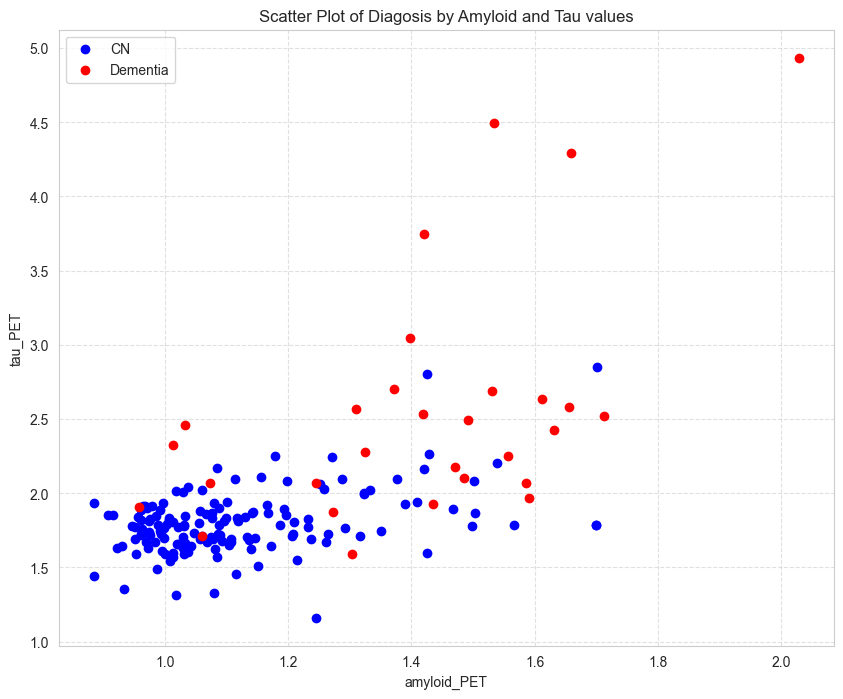

In [ ]:
# Scatterplot of PET values for each group, over the 2 features as the x and y axes

plt.figure(figsize=(10, 8))

# Use same training set as before, which has all rows with any NA values removed
dem_neg = dem_train[dem_train['DX'] == 'CN']
dem_pos = dem_train[dem_train['DX'] == 'Dementia']

plt.scatter(dem_neg['amyloid_PET'], dem_neg['tau_PET'], color='blue', label='CN')
plt.scatter(dem_pos['amyloid_PET'], dem_pos['tau_PET'], color='red', label='Dementia')

plt.title('Scatter Plot of Diagosis by Amyloid and Tau values')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# The plot with the boundary it further down

In [ ]:
linear_model = LinearRegression()

features = ['amyloid_PET', 'tau_PET']
label = 'Dbin'

linear_model.fit(dem_train[features], dem_train[label])

print(linear_model.coef_)
print(linear_model.intercept_)

[0.42816944 0.34853678]
-1.008734265520877


### Calculate decision boundary

The boundary would be given by this formula: 0 = b1x1 + b2x2 + c

=> b2x2 = -b1x1 - c + 0.5

=> x2 = (-b1/b2)x1 + (0.5 - c) / b2

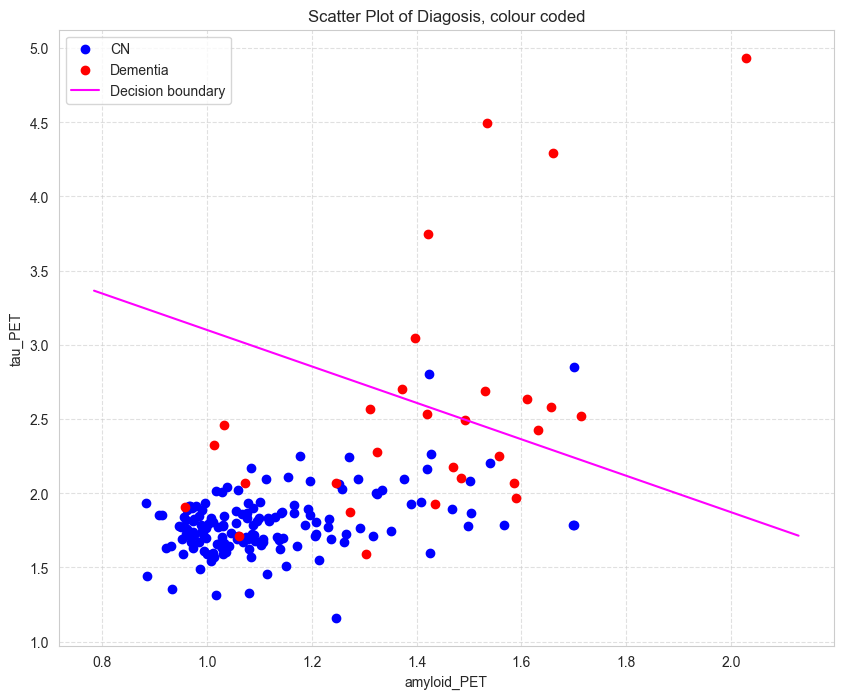

In [ ]:
# Implement formula

b1 = linear_model.coef_[0]
b2 = linear_model.coef_[1]
intercept = linear_model.intercept_

grad = (-b1/b2)
y_intercept = (0.5 - intercept) / b2

# Add the boundary to graph for a general range of values
x_min = dem_train['amyloid_PET'].min() - 0.1
x_max = dem_train['amyloid_PET'].max() + 0.1
x_range = np.linspace(x_min, x_max, 100)
y_boundary = x_range * grad + y_intercept

plt.figure(figsize=(10, 8))

dem_neg = dem_train[dem_train['DX'] == 'CN']
dem_pos = dem_train[dem_train['DX'] == 'Dementia']

plt.scatter(dem_neg['amyloid_PET'], dem_neg['tau_PET'], color='blue', label='CN')
plt.scatter(dem_pos['amyloid_PET'], dem_pos['tau_PET'], color='red', label='Dementia')
plt.plot(x_range, y_boundary, color='magenta', linestyle='-', label='Decision boundary')

plt.title('Scatter Plot of Diagosis, colour coded')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Calculate metrics of boundary on test set

dem_test['linear_pred'] = linear_model.predict(dem_test[['amyloid_PET', 'tau_PET']])

# Predict Dementia when the linear prediction is above 0.5, our threshold
dem_test['bin_pred'] = (dem_test['linear_pred'] > 0.5).astype(int)

In [ ]:
calculate_metrics(dem_test, 'bin_pred')

bin_pred
Sensitivity: 0.6129032258064516
Specificity: 0.967741935483871
Accuracy: 0.896774193548387


## (c) Multimodal Boundary

In [ ]:
# Back to full datasets

dem_train = pd.read_csv('./Dementia_train.csv')
dem_test = pd.read_csv('./Dementia_test.csv')

dem_train.drop(columns='ADAS13', inplace=True)
dem_test.drop(columns='ADAS13', inplace=True)

dem_train.dropna(inplace=True)
dem_test.dropna(inplace=True)

# Encode Dementia label specifically as either 0 or 1

dem_train['Dbin'] = (dem_train['DX'] == 'Dementia').astype(int)
dem_test['Dbin'] = (dem_test['DX'] == 'Dementia').astype(int)

In [ ]:
# EDA

dem_train['DX'].value_counts()

DX
CN          150
MCI          73
Dementia     31
Name: count, dtype: int64

In [ ]:
# Find mean for different diagnosis cases

cn_cases = dem_train[dem_train['DX'] == 'CN'][['amyloid_PET', 'tau_PET']]
mci_cases = dem_train[dem_train['DX'] == 'MCI'][['amyloid_PET', 'tau_PET']]
dem_cases = dem_train[dem_train['DX'] == 'Dementia'][['amyloid_PET', 'tau_PET']]

cn_cases_test = dem_test[dem_test['DX'] == 'CN'][['amyloid_PET', 'tau_PET']]
mci_cases_test = dem_test[dem_test['DX'] == 'MCI'][['amyloid_PET', 'tau_PET']]
dem_cases_test = dem_test[dem_test['DX'] == 'Dementia'][['amyloid_PET', 'tau_PET']]

cn_means = cn_cases.mean()
mci_means = mci_cases.mean()
dem_means = dem_cases.mean()

# Find overall covariance matrix (a simplifying assumping of LDA)

cov = dem_train[['amyloid_PET', 'tau_PET']].cov()

print(cn_means)
print(mci_means)
print(dem_means)
print(cov)

amyloid_PET    1.119657
tau_PET        1.799830
dtype: float64
amyloid_PET    1.164474
tau_PET        2.089793
dtype: float64
amyloid_PET    1.424887
tau_PET        2.669574
dtype: float64
             amyloid_PET   tau_PET
amyloid_PET     0.048542  0.064126
tau_PET         0.064126  0.299147


### Formula for LDA decision boundary between two classes with equal priors: 

(- 0.5) * (m1 - m2).T * cov_inv * (m1 + m2) + x.T * cov_inv * (m1 - m2) = 0

In [ ]:
x_min = dem_train['amyloid_PET'].min() - 0.1
x_max = dem_train['amyloid_PET'].max() + 0.1
x_range = np.linspace(x_min, x_max, 100)

Cov_inv = np.linalg.inv(cov.values)

In [ ]:
# Between CN and Dementia

mu1 = cn_means.values
mu2 = dem_means.values

m = 0.5 * (cn_means + dem_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_cn_dem = (c - w[0] * x_range) / w[1]

# Save the weights from cn/dementia boundary, for use in a later question

c_cnd = c.copy()
w_0_cnd = w[0].copy()
w_1_cnd = w[1].copy()

In [ ]:
# Between CN and MCI

mu1 = cn_means.values
mu2 = mci_means.values

m = 0.5 * (cn_means + mci_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_cn_mci = (c - w[0] * x_range) / w[1]

In [ ]:
# Between MCI and Dementia

mu1 = mci_means.values
mu2 = dem_means.values

m = 0.5 * (mci_means + dem_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_mci_dem = (c - w[0] * x_range) / w[1]

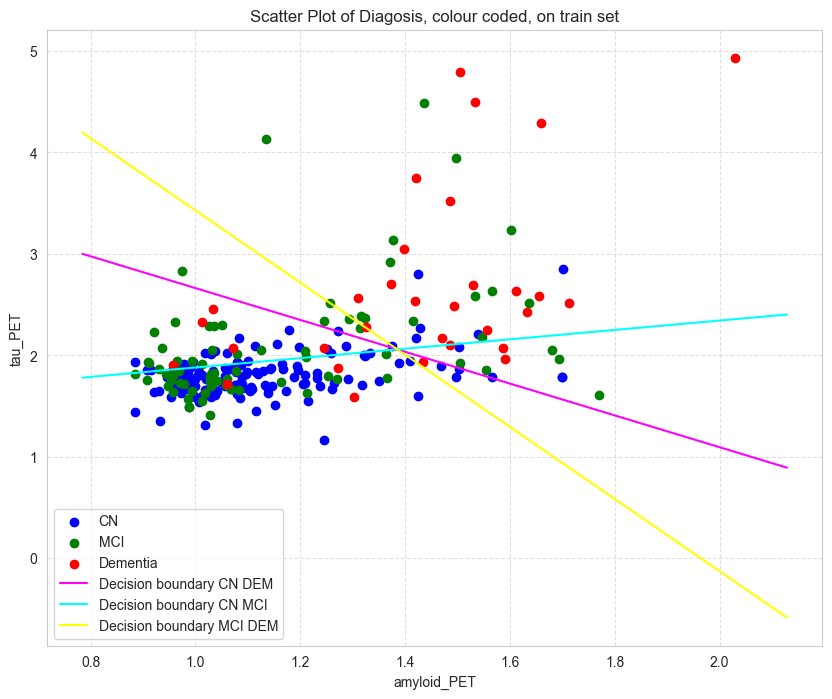

In [ ]:
# Plot for train set data points

y_boundary = x_range * grad + y_intercept

plt.figure(figsize=(10, 8))

plt.scatter(cn_cases['amyloid_PET'], cn_cases['tau_PET'], color='blue', label='CN')
plt.scatter(mci_cases['amyloid_PET'], mci_cases['tau_PET'], color='green', label='MCI')
plt.scatter(dem_cases['amyloid_PET'], dem_cases['tau_PET'], color='red', label='Dementia')

# Add boundaries

plt.plot(x_range, y_cn_dem, color='magenta', linestyle='-', label='Decision boundary CN DEM')
plt.plot(x_range, y_cn_mci, color='cyan', linestyle='-', label='Decision boundary CN MCI')
plt.plot(x_range, y_mci_dem, color='yellow', linestyle='-', label='Decision boundary MCI DEM')

plt.title('Scatter Plot of Diagosis, colour coded, on train set')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

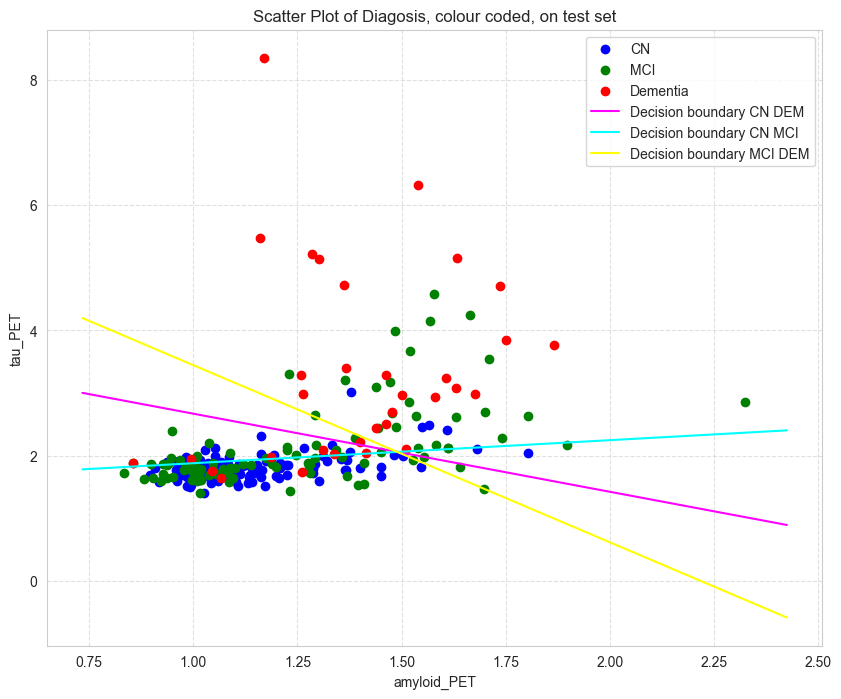

In [ ]:
# Plot for test set data points

x_min = dem_test['amyloid_PET'].min() - 0.1
x_max = dem_test['amyloid_PET'].max() + 0.1
x_range = np.linspace(x_min, x_max, 100)

y_boundary = x_range * grad + y_intercept

plt.figure(figsize=(10, 8))

plt.scatter(cn_cases_test['amyloid_PET'], cn_cases_test['tau_PET'], color='blue', label='CN')
plt.scatter(mci_cases_test['amyloid_PET'], mci_cases_test['tau_PET'], color='green', label='MCI')
plt.scatter(dem_cases_test['amyloid_PET'], dem_cases_test['tau_PET'], color='red', label='Dementia')

# Add boundaries

plt.plot(x_range, y_cn_dem, color='magenta', linestyle='-', label='Decision boundary CN DEM')
plt.plot(x_range, y_cn_mci, color='cyan', linestyle='-', label='Decision boundary CN MCI')
plt.plot(x_range, y_mci_dem, color='yellow', linestyle='-', label='Decision boundary MCI DEM')

plt.title('Scatter Plot of Diagosis, colour coded, on test set')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Remove MCI, keep dementia and cn
dem_test = dem_test[dem_test['DX'] != 'MCI']

# Apply boundary to each test data point
dem_test['boundary_pos'] = ((c_cnd - w_0_cnd * dem_test['amyloid_PET']) / w_1_cnd)

# Predict Dementia or CN, based off of whether the tau value of each test point is higher than the boundary, for it's x value i.e. amyload_PET value. 
# This would put a particular point above the boundary, which is the region that corresponds to Dementia. Dementia gets a bin_pred2 value of 1.

dem_test['bin_pred2'] = (dem_test['tau_PET'] > dem_test['boundary_pos']).astype(int)

In [ ]:
calculate_metrics(dem_test, 'bin_pred2')

bin_pred2
Sensitivity: 0.7575757575757576
Specificity: 0.9212598425196851
Accuracy: 0.8875


# Exercise 2: Gradient Descent

## (a) Rosenblatt Perceptron

In [ ]:
import numpy as np
import pandas as pd
import random

In [ ]:
#implement rosenblatt's perceptron for a 2D example
#Y are the target labels (-1,1)
#X is the input data
#rho is the learning rate
#max_iter controls the maximum number of iterations
##Note: both, rho and max_iter can be left to their default values

#function returns the intercept_ (\beta_0) and the coefficients_ (\beta_i)
def rosen_perceptron(Y, X, rho=0.1, max_iter = 1000):
  #initialize with random parameters
  intercept_ = np.random.randn()
  #as many coefficients as there are columns (features) in X
  coef_ = np.random.randn(X.shape[1])

  #make predictions
  Y_hat = intercept_ + np.dot(X, coef_)

  #compute the list of misclassified samples and store in M
  ########## complete here

  # y_hat counts as a misclassification if it is negative while y is positive or vice versa
  # or equivalently if y * y_hat is negative

  M = [(x, y) for x, y, yh in zip(X, Y, Y_hat) if y * yh < 0]
  ##########

  iter = 0
  #as long as there are misclassified samples in M and we have not reached the
  #maximal number of interations continue to update coefficients etc.
  while len(M) > 0 and iter < max_iter:

    #make gradient step (update intercept and coefficients)
    ########## complete here

    # Update using stochastic gradient descent (using one value of M at a time to update weights)

    # Pick random element in M
    x, y = random.choice(M)
    # Make gradient step
    intercept_  = intercept_ + rho * y
    coef_       = coef_ + rho * x * y
    ##########

    #make predictions using new parameters
    Y_hat = intercept_ + np.dot(X, coef_)

    ##update the list of misclassified samples and store in M
    ########## complete here
    M = [(x, y) for x, y, yh in zip(X, Y, Y_hat) if y * yh < 0]
    ##########

    iter += 1

  return intercept_, coef_

In [ ]:
sim_data = pd.read_csv("./sim_data.csv")

In [ ]:
X = np.array(sim_data[['X1', 'X2']])
Y = np.array(sim_data[['Y']])

In [ ]:
intercepts = []
coeffs = []

for i in range(5):
    intercept, coeff = rosen_perceptron(Y, X)
    print(intercept)
    print(coeff)
    intercepts.append(intercept)
    coeffs.append(coeff)

[0.73176318]
[-0.1946941  -0.27299005]
[0.54040491]
[-0.13243574 -0.1604333 ]
[1.67607544]
[-0.55417677 -0.65160353]
[1.09470381]
[-0.2942744  -0.31707124]
[0.87518326]
[-0.24924484 -0.28047512]


### The boundary is where b1x1 + b2x2 + beta = 0, therefore it's where x2 = (-b1x1 -beta) / b2

100


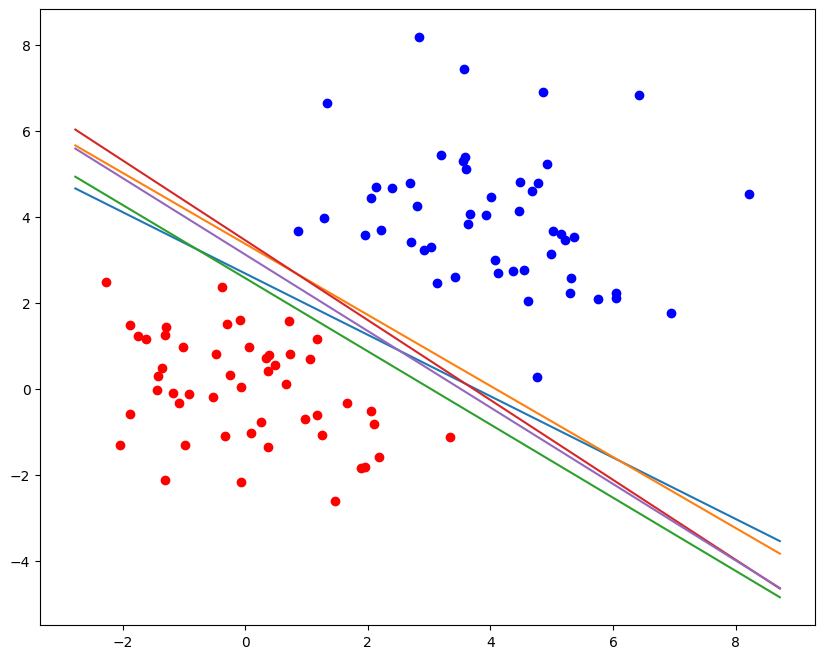

In [ ]:
sim_data_pos = sim_data[sim_data['Y'] == 1]
sim_data_neg = sim_data[sim_data['Y'] == -1]

print(len(sim_data_neg) + len(sim_data_pos))

plt.figure(figsize=(10, 8))
plt.scatter(sim_data_pos['X1'], sim_data_pos['X2'], color='red')
plt.scatter(sim_data_neg['X1'], sim_data_neg['X2'], color='blue')

x_min = sim_data['X1'].min() - 0.5
x_max = sim_data['X1'].max() + 0.5

x_range = np.linspace(x_min, x_max, 100)

for i in range(5):
    intercept = intercepts[i]
    coeff = coeffs[i]

    boundary_y = (-coeff[0] * x_range - intercept) / coeff[1]

    plt.plot(x_range, boundary_y, linestyle='-', label=f'Decision boundary {i}')


## (b) Logistic Regression with Gradient Descent

## Cost function and gradient

### Cost function
$$J(\beta) = - \frac{1}{m} \sum_{i=1}^{m} [ y_i \cdot \log(p(x_i;\beta)) + (1 - y_i) \cdot \log(1 - p(x_i;\beta)) ] = - \frac{1}{m} \sum_{i=1}^{N} \{ y_i \beta^T x_i - \log(1 + \exp(\beta^T x_i)) \}$$

### This is equal to -1/m times the log likehood (included 1/m to get the average cost per data point, where m is the number of datapoints. Included - to turn the log likelihood into a cost function)

### Gradient:
$$\frac{\delta J(\beta)}{\delta \beta} = - \frac{1}{m} \sum_{i=1}^{N} x_i(y_i - p(x_i; \beta)) = - \frac{1}{m} X^{T}(y - p)$$

In [ ]:
import numpy as np
from scipy.special import expit

In [ ]:
class LogRegGrad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  def _sigmoid(self, value):
    return expit(value)

  #predicts class probabilities
  def predict(self, X):
    prob1 = self._sigmoid( X @ self._betas)
    prob0 = 1.0 - prob1
    #make both probs 'stable'
    prob1[prob1 == 0.0] = 10**-10
    prob0[prob0 == 0.0] = 10**-10
    return prob0, prob1

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameters as required
  def _compute_cost(self, y, prob0, prob1):
    ###
    # The Log loss cost function would be the negative of the log-likelihood
    # Take the mean cost
    my_cost = - np.mean(y @ np.log(prob1) + (1 - y) @ np.log(prob0))
    ###

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameteres as required
  def _compute_gradient(self, X, y, prob1):
    ###
    # Take "mean" gradient
    grad = (-1 / self._N) * (X.T @ (y - prob1))
    ###
    return grad

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # alpha is the learning rate
  def fit(self, y, features, alpha=0.1):

    # Format data to numpy array
    if not isinstance(y, np.ndarray):
      y = np.array(y)
      
    if not isinstance(features, np.ndarray):
      features = np.array(features)

    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    prob0, prob1 = self.predict(X)

    ######################## complete here
    cost = self._compute_cost(y, prob0, prob1)
    ########################
    self._loss = []
    niter = 0
    while niter < self._max_iter:
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, prob1)
        self._betas -= grad * self._alpha
        ########################
        prob0, prob1 = self.predict(X)
        #recompute cost
        ####################### complete here
        cost = self._compute_cost(y, prob0, prob1)
        #######################
        niter += 1

In [ ]:
pd_data = pd.read_csv('PD_data.csv')
print(pd_data['Unnamed: 0'])

0        0
1        1
2        2
3        3
4        4
      ... 
202    202
203    203
204    204
205    205
206    206
Name: Unnamed: 0, Length: 207, dtype: int64


In [ ]:
pd_data = pd.read_csv('PD_data.csv')

# EDA

# Remove first column since it only contains indexes
pd_data = pd_data.iloc[:, 1:]

print(pd_data.info())
#No NA values, no need to dropna
print(pd_data.describe())
print(pd_data['DX'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 85 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LLatVent                           207 non-null    float64
 1   RLatVent                           207 non-null    float64
 2   Lthal                              207 non-null    float64
 3   Rthal                              207 non-null    float64
 4   Lcaud                              207 non-null    float64
 5   Rcaud                              207 non-null    float64
 6   Lput                               207 non-null    float64
 7   Rput                               207 non-null    float64
 8   Lpal                               207 non-null    float64
 9   Rpal                               207 non-null    float64
 10  Lhippo                             207 non-null    float64
 11  Rhippo                             207 non-null    float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features to improve the gradient descent algorithms
min_max_scaler = MinMaxScaler()

features = np.array(pd_data.iloc[:, :-1])
labels = np.array(pd_data.iloc[:, -1])

min_max_scaler.fit_transform(features)
features = min_max_scaler.transform(features)

In [ ]:
from sklearn.linear_model import LogisticRegression

model_sk = LogisticRegression()

model_sk.fit(features, labels)

all_coef_sk = [model_sk.intercept_[0]] + list(model_sk.coef_[0])

In [ ]:
model_custom = LogRegGrad(niter=3000)

model_custom.fit(labels, features, alpha=0.1)

In [ ]:
model_custom._betas

array([ 1.00937207,  0.4080549 ,  1.90675431,  1.99749321, -0.12283129,
        0.61363557,  0.85032238, -0.42523856, -0.36171763,  0.41037426,
        0.28925697,  0.67052186,  0.07285811,  0.93850218,  0.55252539,
        0.13055866, -0.22787057,  0.80693051,  0.59997023,  1.17161993,
        0.38543267,  0.8369217 ,  1.62379846, -0.45047275, -0.53141119,
        1.29597942, -0.61250955, -0.67097105,  0.196971  ,  0.01912905,
       -0.79039905,  0.56198874,  1.13760747,  0.88777385,  0.82125175,
       -0.81195332, -0.08696701,  0.24856337,  0.77490733, -1.77855969,
       -0.67423153,  0.07366824, -0.75528923, -0.29521028,  0.01305441,
        0.10519051, -0.57414316, -0.15884368, -0.46136549, -0.14963733,
       -0.36365434,  0.4760021 ,  0.67361147, -0.33278847, -1.26406518,
       -1.29217158, -0.81817454,  0.713787  , -1.05764453, -0.72997175,
       -0.34509862, -0.6206295 , -0.17973239,  0.49247487, -0.90984508,
       -0.7371066 , -0.51430548, -0.17221261,  0.25433502,  0.17

Text(0, 0.5, "Sk learn model's coeffs")

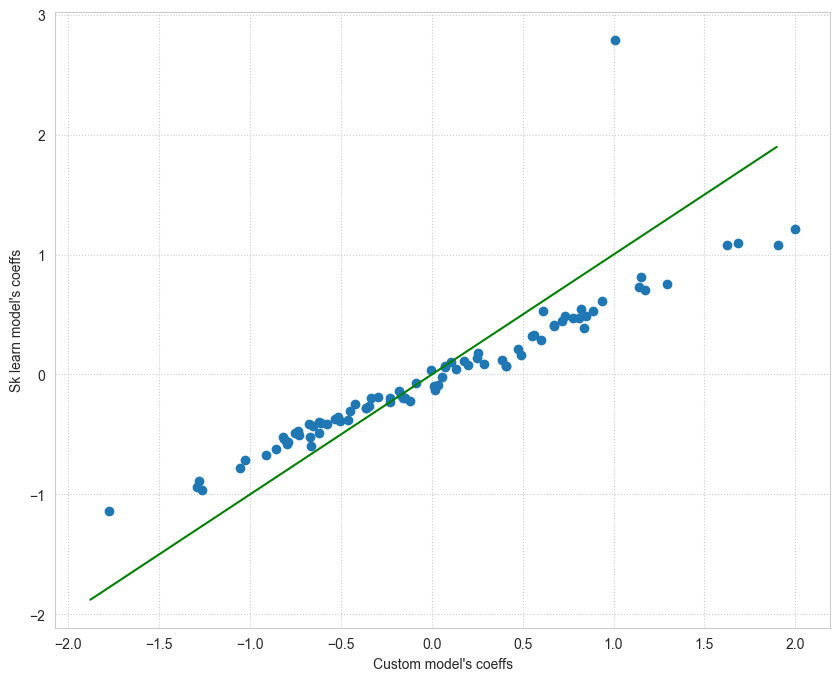

In [ ]:
plt.figure(figsize=(10, 8))

all_features = list(pd_data.columns[:-1]) + ["intercept"]

x_min = model_custom._betas.min() - 0.1
x_max = model_custom._betas.max() - 0.1
x_range = np.linspace(x_min, x_max, 1000)

plt.scatter(model_custom._betas, all_coef_sk)
plt.plot(x_range, x_range, color='green', linestyle='-')
plt.grid(True, linestyle=':')
plt.xlabel("Custom model's coeffs")
plt.ylabel("Sk learn model's coeffs")

In [ ]:
# Checking training set scores of both models, as a double check

from sklearn.metrics import roc_auc_score

pred_sk = model_sk.predict_proba(features)[:, 1]

print(roc_auc_score(labels, pred_sk))

pred_custom = model_custom.predictNew(features)[1]

print(roc_auc_score(labels, pred_custom))

0.880709071949948
0.8905109489051095


### Coeffs look very similar for most features, but not the same. I notice most coefficients of my custom model are larger than the Sklearn model. This could be due to the LogisticRegression from sklearn having an l2 regularizer built in by default, which would stunt the growth of certain features, pushing them downwards

## (C) Hinge Loss and L1 regularization with gradient descent

## Cost function and gradient

### Cost function
$J(\beta) = \left[ \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - y_i(\beta_0 + \beta^\top x_i)) \right] + \lambda \sum_{j=1}^{p} |\beta_j|$

### Where p is the number of features, and N the number of datapoints

### Gradient:
$\frac{\delta J(\beta)}{\delta \beta} = \left( \frac{1}{N} \sum_{i=1}^{N} \begin{cases} -y_i x_i & \text{if } y_i(\beta_0 + \beta^\top x_i) < 1 \\ 0 & \text{if } y_i(\beta_0 + \beta^\top x_i) \ge 1 \end{cases} \right) + \lambda  \text{sign}(\beta_j)$

### Where we assume that x0 is equal to one, in order to get beta0's gradient

In [ ]:
class HingeL1Grad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  #predicts class probabilities
  def predict(self, X):
    yhat = X @ self._betas
    return yhat

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameteres as needed
  def _compute_cost(self, X, y, yhat, lam):
    #compute the cost
    ######
    reg_cost = lam * np.sum(np.abs(self._betas))
    mean_hinge_cost = np.sum(np.maximum(1 - (y * yhat), np.zeros(self._N)))
    my_cost = (mean_hinge_cost + reg_cost) / self._N
    ######

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameters as needed
  def _compute_gradient(self, X, y, yhat, lam):
    #########
    output = y.copy()
    zero_mask = (y * yhat) >= 1
    output[zero_mask] = 0
    hinge_grad = -output @ X
    reg_grad = lam * np.sign(self._betas)
    grad = hinge_grad + reg_grad
    #########
    # Choosing to take the mean of both the hinge part of the loss, and the regularizing part.
    return grad / self._N

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # lam is the regularization strength (lambda)
  # alpha is the learning rate
  def fit(self, y, features, lam=0, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    yhat = self.predict(X)

    ########### complete here
    cost = self._compute_cost(X, y, yhat, lam)
    ###########
    self._loss = []
    niter = 0

    while niter < self._max_iter:
        niter += 1
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, yhat, lam)
        self._betas -= grad * self._alpha
        ########################
        yhat = self.predict(X)
        ####################### complete here
        cost = self._compute_cost(X, y, yhat, lam)
        #######################

In [ ]:
# Use same features and labels as 2b, but make 0 labels into -1

labels[labels == 0] = -1

model_custom = HingeL1Grad(niter=3000)

model_custom.fit(labels, features, lam=5, alpha=0.001)

model_custom._betas

array([ 2.29869565e-01,  7.28282018e-02,  1.00208117e-01,  7.44715302e-02,
        3.10834792e-02,  3.88089314e-02,  7.07887440e-02,  1.45175102e-02,
        8.56810212e-06,  8.78235443e-02,  5.38112631e-02,  1.69757656e-02,
        1.18347593e-05,  3.90291002e-02,  1.99039611e-02,  2.13597885e-02,
        4.43415933e-02,  2.95301462e-02,  6.39909408e-02,  4.81363618e-02,
        1.38313653e-02,  6.45043325e-02,  2.96484585e-02,  2.65849171e-05,
       -1.77175852e-05,  3.25601315e-02,  1.07923545e-05,  2.73169618e-05,
        3.46054863e-06,  2.84711216e-02,  2.67396314e-05,  5.95086834e-02,
        8.94154183e-02,  6.18190205e-02,  2.75112141e-05, -1.06699523e-05,
        2.21814694e-05,  1.25716162e-05,  3.15810834e-02, -1.51268073e-05,
       -7.36345588e-06,  2.08092799e-02, -1.78162767e-05, -1.09357179e-05,
        2.48835680e-02, -2.21981887e-05,  9.25752149e-06,  5.44728463e-04,
        4.44700134e-02, -8.43696511e-06,  1.47945683e-05,  3.46823349e-02,
        3.14569502e-02,  

Text(0, 0.5, "Sk learn model's coeffs")

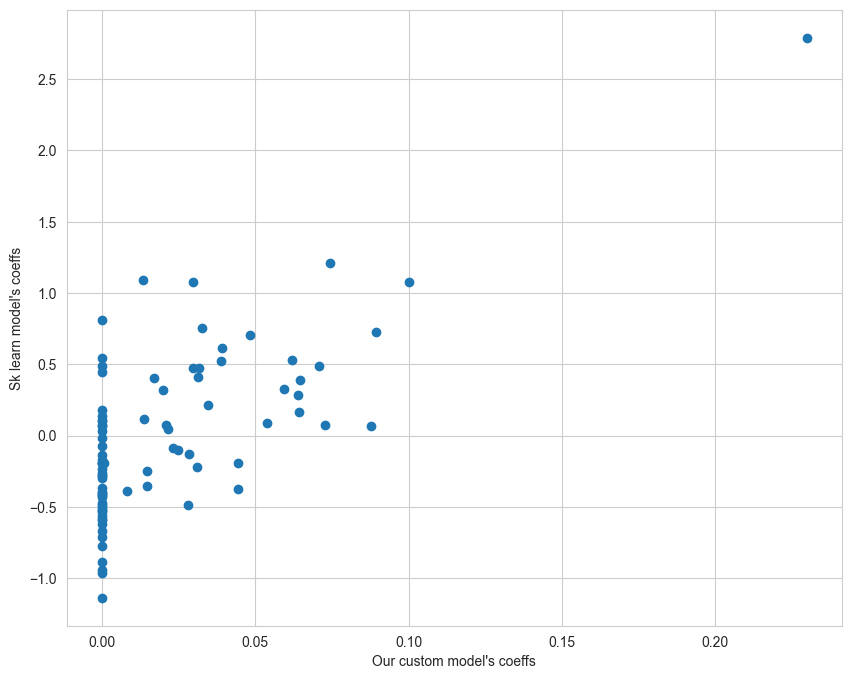

In [ ]:
plt.figure(figsize=(10, 8))

all_features = list(pd_data.columns[:-1]) + ["intercept"]

plt.scatter(model_custom._betas, all_coef_sk)
plt.xlabel("Our custom model's coeffs")
plt.ylabel("Sk learn model's coeffs")

### Our model has a lot of zero betas which aren't zero in the sklearn LR model. This is caused by the strong L1 regularization

## (d) ADAM
Copy either your solution ffrom (b) or (c) and modify the fit function to implement ADAM (momentum + RMSprop) as introduced in the lectures

In [ ]:
class HingeL1GradAdam:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    #Momentum constant, using popular choice
    self._gamma1 = 0.9

    #RMS prop constants, using popular choice
    self._gamma2 = 0.999
    self._eps = 1e-8

    #m momentum
    self.m = 0

    #s second momentum
    self.s = 0

    self._loss = []

  #predicts class probabilities
  def predict(self, X):
    yhat = X @ self._betas
    return yhat

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameteres as needed
  def _compute_cost(self, X, y, yhat, lam):
    #compute the cost
    ######
    reg_cost = lam * np.sum(np.abs(self._betas))
    mean_hinge_cost = np.sum(np.maximum(1 - (y * yhat), np.zeros(self._N)))
    my_cost = (mean_hinge_cost + reg_cost) / self._N
    ######

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameters as needed
  def _compute_gradient(self, X, y, yhat, lam):
    #########
    output = y.copy()
    zero_mask = (y * yhat) >= 1
    output[zero_mask] = 0
    hinge_grad = -output @ X
    reg_grad = lam * np.sign(self._betas)
    grad = hinge_grad + reg_grad
    #########
    # Choosing to take the mean of both the hinge part of the loss, and the regularizing part.
    return grad / self._N


  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # lam is the regularization strength (lambda)
  # alpha is the learning rate
  def fit(self, y, features, lam=0, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    yhat = self.predict(X)

    ########### complete here
    cost = self._compute_cost(X, y, yhat, lam)
    ###########
    self._loss = []
    niter = 0

    while niter < self._max_iter:
        niter += 1
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, yhat, lam)

        # Implement ADAM
        self.m = self._gamma1 * self.m + (1 - self._gamma1) * grad

        self.s = self._gamma2 * self.s + (1 - self._gamma2) * grad**2

        # Correct bias in estimates
        m_cor = self.m / (1 - self._gamma1**niter)
        s_cor = self.s / (1 - self._gamma2**niter)

        adam_update = -self._alpha * m_cor / (np.sqrt(s_cor) + self._eps)
        
        self._betas += adam_update
        ########################
        yhat = self.predict(X)
        ####################### complete here
        cost = self._compute_cost(X, y, yhat, lam)
        #######################

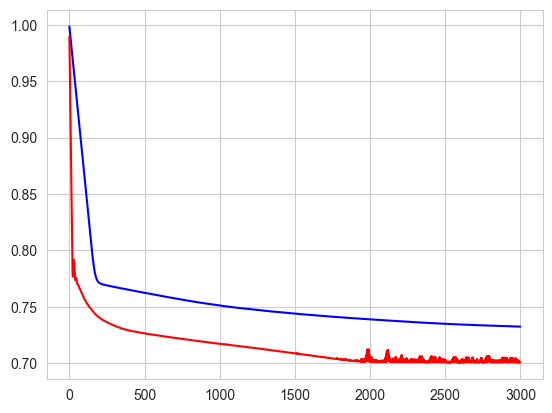

In [ ]:
model_custom_adam = HingeL1GradAdam(niter=3000)

model_custom_adam.fit(labels, features, lam=5, alpha=0.001)

plt.plot(model_custom._loss, color='blue')
plt.plot(model_custom_adam._loss, color='red')

### We can see that the ADAM model converges much more quickly than the first model... it ends up at a lower overall cost as well, converging downwards much more quickly. This is because the combination of Momentum and RMSProp in Adam make the gradient descent much quicker

# Exercise 3: Hippocampus segmentation


### I added a random seed to a few of the functions, to make subsamples/selections/results reproducible

In [ ]:
#useful to unzip the data when working on Colab
import zipfile
unzip_data = True

if unzip_data:
  with zipfile.ZipFile("./hippocampus.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [3]:
import numpy as np
import sklearn
import nibabel as nib
import matplotlib.pyplot as plt
import skimage
import sys
from scipy import ndimage
from os import listdir
from os.path import isfile, join
import time
import pandas as pd
import gc

In [38]:
data_path = './'
train_path= data_path + "imagesTr/"
test_path= data_path + "imagesTest/"
vali_path= data_path + "imagesVali/"

labels_train = data_path + "labelsTr/"
labels_test = data_path + "labelsTest/"
labels_vali = data_path + "labelsVali/"


In [39]:
#displays three slices of the 3D volume at the specified x, y, z values
#over: provide an ndarray that is treated as an overlay
#overcut: specify a cutoff value for the overlay, smaller values will not be displayed
def displayNii(dat, x=18, y=29, z=18, over=None, overcut = 0.0, mycmap="gray"):
  fig, axs = plt.subplots(1, 3, figsize=(6, 10), gridspec_kw={'width_ratios': [2, 1.5, 1]})

  idx = None
  axs[0].imshow(dat[x,:,::-1].T, cmap=mycmap)
  axs[1].imshow(dat[::-1,y,::-1].T, cmap=mycmap)
  axs[2].imshow(dat[::-1,::-1,z].T, cmap=mycmap)

  axs[0].set_title('x=' + str(x))
  axs[1].set_title('y=' + str(y))
  axs[2].set_title('z=' + str(z))

  if over is not None:
    idx = over.copy()
    idx[idx <= overcut] = None
    axs[0].imshow(idx[x,:,::-1].T, alpha=0.5)
    axs[1].imshow(idx[::-1,y,::-1].T, alpha=0.5)
    axs[2].imshow(idx[::-1,::-1,z].T, alpha=0.5)

  axs[0].axis('off')
  axs[1].axis('off')
  axs[2].axis('off')
  plt.show()

In [40]:
#load the image along with the segmentation mask of subject with id 'id'
def load_image(id, img_folder, lab_folder):
  img = nib.load(img_folder + "hippocampus_" + id + ".nii.gz")
  lab = nib.load(lab_folder + "hippocampus_" + id + ".nii.gz")

  data_raw = img.get_fdata()
  #do a min-max normalization of the entire image
  A = np.min(data_raw)
  B = np.max(data_raw)
  data_norm = (data_raw - A) / (B - A) * 1000

  #all pixles labeled 1 or 2 are part of the hippocampus
  data_lab = (lab.get_fdata() > 0) * 1.0

  return data_norm, data_lab

In [41]:
#compute a range of fliteres as additional channels
def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)
  #concatenate original image with
  tmp = [ res, sob, gau2 - gau ]
  res = np.stack( tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

In [42]:
#extracts a feature vectors from a given image with id 'imgid'
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sfreq' is returned
def extractFeatures(imgid, img_folder, lab_folder, pdim=3, sfreq=0.01, verbose=False):

  #load raw image
  dat_norm, lab = load_image(imgid, img_folder, lab_folder)

  #compute extra channels
  dat = preprocess_img(dat_norm)

  #add dimension to lab if needed (in case we have >1 channel in dat)
  if len(dat.shape) > 3:
    lab = np.expand_dims(lab, 3)
    tmp = np.concatenate( [dat, lab], axis=3)
  else:
    tmp = np.stack((dat, lab),3)

  #total channels
  xdim = tmp.shape[3]

  #make all possible patches/cubes
  patches = skimage.util.shape.view_as_windows(tmp, (pdim,pdim,pdim,xdim))

  if verbose:
    print (patches.shape)

  np.random.seed(123)

  #sample patches randomly with frequency sfreq
  #e.g., sfreq=0.01 will sample 1% of all patches/cubes
  mysample = np.random.choice(2, size=patches.shape[:3], replace=True, p=[1-sfreq, sfreq]) == 1

  #midpoint of the cube
  midp = int((pdim - 1)/2)

  #central pixel
  labels   = patches[mysample][:,0,midp,midp,midp,xdim-1]
  features = patches[mysample][:,0,:,:,:,:(xdim-1)]
  #flatten each feature vector
  features_flat = features.reshape(features.shape[0], pdim*pdim*pdim*(xdim-1))

  return labels, features_flat

In [43]:
#extracts a feature vectors from all images in a given folder
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sample_freq' is returned
def create_training_set(img_folder, lab_folder, pdim=5, sample_freq=0.01, verbose=False):
  Y = []
  sample_id = []

  #get list of all files in img_folder:
  my_files = [f for f in listdir(img_folder) if isfile(join(img_folder, f))]
  my_files_short = [f.replace("hippocampus_","").replace(".nii.gz","") for f in my_files]
  my_files_short.sort()

  #load first image to estimate number of channels
  dat, _ = load_image(my_files_short[0], img_folder, lab_folder)
  fdim = preprocess_img(dat, only_dim=True)

  print("Extracting cubes of size " + str(pdim) + "^3 and " + str(fdim) + " channels. Sampling with frequency " + str(sample_freq) + " from each image.")

  #create the feature matrix
  X = np.empty((0,pdim**3*fdim))
  for id in my_files_short:
    if verbose:
      sys.stdout.write("working on Image ID: " + id + "\n")
    #extract the labels and the flat feature vecotr from all extracted patches
    labels, features = extractFeatures(id, img_folder, lab_folder, pdim, sfreq=sample_freq, verbose=False)
    #keep track of the matchin labels
    Y.extend(labels)
    #keep track from which image the samples were taken
    sample_id.extend([id] * len(labels))
    #append the features extracted from of sampled cubse of the image to the training data
    X = np.concatenate((X, features), axis=0)
  Y = np.array(Y)
  return Y, X, sample_id


In [44]:
#this function takes X and Y as input and
#oversamples the target class ('1') with a ratio:1 ratio (default: None)
# if ratio is None, then it will be set to 1/f, where f is the frequency
# of the target class
#from the overall size of X a sub_sample of 'sample_size' is randomly selected


def sub_sample(X, Y, sample_size=10000, ratio=None):
    #compute class 1 frequency
    rtclass = np.sum(Y)/len(Y)
    if ratio is None:
        ratio = 1.0/rtclass
        print("sampling with ratio 1:" + str(ratio))
    weights = np.array([1] * len(Y))
    weights[Y==1] = ratio
    weights = weights/np.sum(weights)

    np.random.seed(123)

    #sample sample_size of the generated patches
    idx = np.random.choice(X.shape[0],sample_size,replace=False, p=np.array(weights))

    Xsub = X[idx,:]
    Ysub = np.array(Y)[idx]

    #return subsets of X, Y and the selection index
    return Xsub, Ysub, idx

In [45]:
#example of loading a nifti file
data, data_lab = load_image("001", train_path, labels_train)

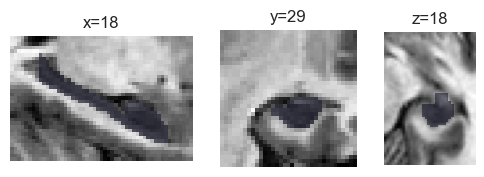

In [46]:
displayNii(data, over=data_lab, overcut=0.0)

In [47]:
#read all images in the path containing the training images and extract feature vectures
#cobe dimension is set to 5 x 5 x 5
Y, X, sampleIDs = create_training_set(train_path, labels_train, pdim=5)

Extracting cubes of size 5^3 and 3 channels. Sampling with frequency 0.01 from each image.


In [48]:
#subsample as per instructions
Xsub, Ysub, sub_idx = sub_sample(X, Y, 1000)

sampling with ratio 1:13.565581395348838


In [49]:
#the initial X and Y matrices are quite large and
#clutter the memory, we don't require these for further processing
#so setting them to None and calling the garbage collector
#will preserve resources
import gc
X = None
Y = None
gc.collect()

16602

## (a) Train SVC with polynomial and RBF kernel

In [50]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

### I choose stratified Kfold to make the final averaged validation scores slightly more robust, since each split will have a validation set that has the same (almost the same because of rounding) proportion of true labels as the full dataset

### I omitted the linear kernel since it had horrendous runtimes on my machine. LinearSCV is another option which runs much faster, but uses a slightly different default loss function and regularization, so I chose not to compare it.

In [51]:
hyper_param_grid = {
    'kernel': [
        'rbf', 
        # 'linear', 
        'poly'
    ],
    'C': [10**k for k in range(-1, 4)]
}

svc = SVC(degree=3, random_state=42)

# Set splitter, to make splits stratified based on the labels for more robust metrics, and to 
# enforce a random state, for the sake of reproducible results

cv_splitter = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

clf = GridSearchCV(
    estimator=svc, 
    param_grid=hyper_param_grid, 
    cv=cv_splitter,
    scoring='roc_auc', 
    n_jobs=-1,
)

# linear_svc = LinearSVC()

# clf_linear = GridSearchCV(
#     estimator=linear_svc, 
#     param_grid={'C': [10**k for k in range(-1, 4)]}, 
#     scoring='roc_auc', 
#     n_jobs=5,
#     cv=5,
# )

In [52]:
clf.fit(Xsub, Ysub)

,estimator,SVC(random_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'kernel': ['rbf', 'poly']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [53]:
results_df = pd.DataFrame(
    {
        'C': clf.cv_results_['param_C'],
        'Kernel': clf.cv_results_['param_kernel'],
        'Mean_AUC_score': clf.cv_results_['mean_test_score'],
    }
) 

results_df['Rank'] = results_df['Mean_AUC_score'].rank(ascending=False)

results_df

,C,Kernel,Mean_AUC_score,Rank
0,0.1,rbf,0.781004,10.0
1,0.1,poly,0.802776,8.0
2,1.0,rbf,0.852487,2.0
3,1.0,poly,0.825810,6.0
4,10.0,rbf,0.863544,1.0
5,10.0,poly,0.833360,5.0
6,100.0,rbf,0.834939,3.0
7,100.0,poly,0.813730,7.0
8,1000.0,rbf,0.833457,4.0
9,1000.0,poly,0.787053,9.0


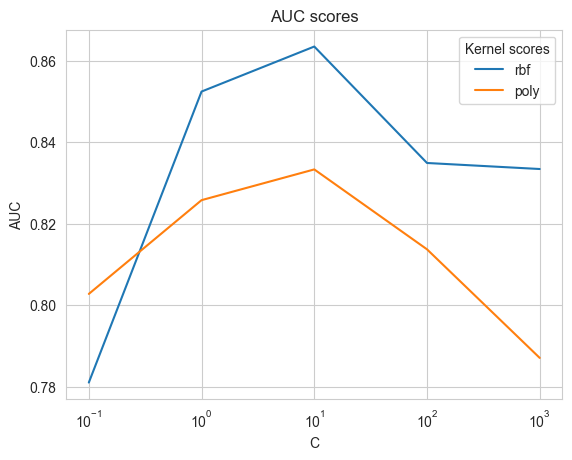

In [54]:
import seaborn as sns

sns.set_style("whitegrid")

sns.lineplot(
    data=results_df,
    x='C',
    y='Mean_AUC_score',
    hue='Kernel',
)

plt.xscale('log')

plt.title('AUC scores')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend(title='Kernel scores')
plt.show()

### Best model parameters: RBF kernel with C = 10

In [55]:
from sklearn.model_selection import train_test_split

svcbest = SVC(C=10, kernel='rbf', random_state=42)

svcbest.fit(Xsub, Ysub)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## (b) Apply to validation data, compute DICE and AUC

### Make validation version of create_training_set function, with modifications for validation

In [56]:
def create_vali_set(img_folder, lab_folder, pdim=5, sample_freq=1, verbose=False):

  sample_ids = []

  #get list of all files in img_folder:
  my_files = [f for f in listdir(img_folder) if isfile(join(img_folder, f))]
  my_files_short = [f.replace("hippocampus_","").replace(".nii.gz","") for f in my_files]
  my_files_short.sort()

  #load first image to estimate number of channels
  dat, _ = load_image(my_files_short[0], img_folder, lab_folder)
  fdim = preprocess_img(dat, only_dim=True)

  print("Extracting cubes of size " + str(pdim) + "^3 and " + str(fdim) + " channels. Sampling with frequency " + str(sample_freq) + " from each image.")

  #create the feature matrix

  Xs = []
  Ys = []
  full_imgs = []
  full_labs = []
  for id in my_files_short:
    if verbose:
      sys.stdout.write("working on Image ID: " + id + "\n")
    #extract the labels and the flat feature vecotr from all extracted patches
    labels, features = extractFeatures(id, img_folder, lab_folder, pdim, sfreq=sample_freq, verbose=False)
    #keep track of the matchin labels

    #keep track from which image the samples were taken
    sample_ids.extend([id] * len(labels))
    #append the features extracted from of sampled cubse of the image to the training data

    Xs.append(features)
    Ys.append(labels)
    x, y = load_image(id, img_folder, lab_folder)
    full_imgs.append(x)
    full_labs.append(y)

    sample_ids = sorted(list(set(sample_ids)))

  return Ys, Xs, full_imgs, full_labs, sample_ids

In [57]:
def output_vali_results(Ys, Xs, full_imgs, full_labs, sample_ids, pdim, model, verbose=True):
    roc_list = []
    dice_list = []
    best_prediction = 0
    best_dice_score = 0
    best_id = 0

    if pdim % 2 != 1:
        print("Cube size must be odd!")
        return

    pad_width = int((pdim - 1) / 2)

    for i in range(len(Ys)):

        id = sample_ids[i]
        full_lab = full_labs[i]
        
        prediction = model.predict(Xs[i])
        prediction_full = prediction.reshape(
            full_lab.shape[0] - pad_width * 2,
            full_lab.shape[1] - pad_width * 2,
            full_lab.shape[2] - pad_width * 2,
        )
        # Predict 0 for the outer 2 layers of the images, since the 5x5x5 cubes of features used for
        # prediction won't extend to give predictions on those sides
        prediction_full = np.pad(prediction_full, pad_width=pad_width, mode='constant', constant_values=0)

        roc_auc = roc_auc_score(prediction_full.flatten(), full_lab.flatten())

        # Dice Score is equivalent to f1 score when looking at each pixel as a separate prediction
        dice_score = f1_score(prediction_full.flatten(), full_lab.flatten())

        roc_list.append(roc_auc)
        dice_list.append(dice_score)

        if dice_score > best_dice_score:
            best_id = id
            best_prediction = prediction_full

        if verbose:
            print(f'For image {sample_ids[i]}: ROC AUC: {roc_auc}, Dice Score: {dice_score}')

    return roc_list, dice_list, best_id, best_prediction

In [58]:
# Get validation set details

Ys, Xs, full_imgs, full_labs, sample_ids = create_vali_set(vali_path, labels_vali, pdim=5, sample_freq=1, verbose=True)

Extracting cubes of size 5^3 and 3 channels. Sampling with frequency 1 from each image.
working on Image ID: 380
working on Image ID: 381
working on Image ID: 383
working on Image ID: 385
working on Image ID: 386
working on Image ID: 387
working on Image ID: 389
working on Image ID: 390
working on Image ID: 393
working on Image ID: 394


In [59]:
roc_list, dice_list, best_id, best_prediction = output_vali_results(
    Ys, Xs, full_imgs, full_labs, sample_ids, pdim=5, model=svcbest
)

For image 380: ROC AUC: 0.6018383665668039, Dice Score: 0.3405169767299073
For image 381: ROC AUC: 0.6037021044879591, Dice Score: 0.3444837800736941
For image 383: ROC AUC: 0.6211483469229635, Dice Score: 0.391356038883838
For image 385: ROC AUC: 0.606463966932176, Dice Score: 0.3523078826877862
For image 386: ROC AUC: 0.5959181177714602, Dice Score: 0.3237196765498652
For image 387: ROC AUC: 0.6206522809205812, Dice Score: 0.3890546539553162
For image 389: ROC AUC: 0.5919465026355419, Dice Score: 0.31694540864626064
For image 390: ROC AUC: 0.5948005875386285, Dice Score: 0.32253877603997666
For image 393: ROC AUC: 0.639650894819086, Dice Score: 0.434353811382782
For image 394: ROC AUC: 0.6286873112708685, Dice Score: 0.4080942156288633


In [60]:
# Average scores

print(f'Average validation ROC AUC: {np.mean(roc_list)}')
print(f'Average validation Dice Score: {np.mean(dice_list)}')

Average validation ROC AUC: 0.6104808479866068
Average validation Dice Score: 0.362337122057829


### I modify the display function to help display the best image with labels and predictions

In [91]:
#displays three slices of the 3D volume at the specified x, y, z values
#over: provide an ndarray that is treated as an overlay
#overcut: specify a cutoff value for the overlay, smaller values will not be displayed
def displayNew(dat, x=18, y=29, z=18, over=None, overcut = 0.0, mycmap="gray", cmap_lab='Reds'):
  fig, axs = plt.subplots(1, 3, figsize=(6, 10), gridspec_kw={'width_ratios': [2, 1.5, 1]})

  dat_min = dat.min()
  dat_max = dat.max()
  over_min = over.min()
  over_max = over.max()

  idx = None
  axs[0].imshow(dat[x,:,::-1].T, cmap=mycmap, vmin=dat_min, vmax=dat_max)
  axs[1].imshow(dat[::-1,y,::-1].T, cmap=mycmap, vmin=dat_min, vmax=dat_max)
  axs[2].imshow(dat[::-1,::-1,z].T, cmap=mycmap, vmin=dat_min, vmax=dat_max)

  axs[0].set_title('x=' + str(x))
  axs[1].set_title('y=' + str(y))
  axs[2].set_title('z=' + str(z))

  if over is not None:
    idx = over.copy()
    idx[idx <= overcut] = None
    axs[0].imshow(idx[x,:,::-1].T, alpha=0.5, cmap=cmap_lab, vmin=over_min, vmax=over_max)
    axs[1].imshow(idx[::-1,y,::-1].T, alpha=0.5, cmap=cmap_lab, vmin=over_min, vmax=over_max)
    axs[2].imshow(idx[::-1,::-1,z].T, alpha=0.5, cmap=cmap_lab, vmin=over_min, vmax=over_max)

  axs[0].axis('off')
  axs[1].axis('off')
  axs[2].axis('off')
  plt.show()

True label


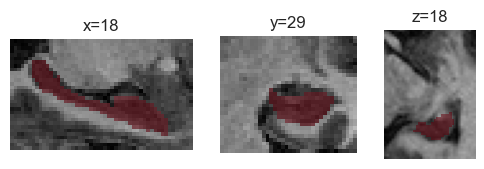

Prediction


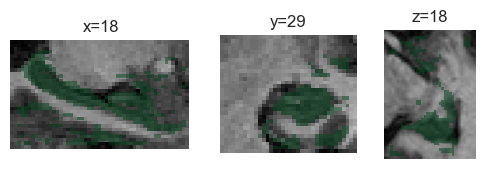

In [62]:
# Best performance on id 393:

best_id = 393

#example of loading a nifti file
data, data_lab = load_image(str(best_id), vali_path, labels_vali)
print('True label')
displayNew(data, over=data_lab, overcut=0.0, cmap_lab='Reds')
data, data_lab = load_image(str(best_id), vali_path, labels_vali)
print('Prediction')
displayNew(data, over=best_prediction, overcut=0.0, cmap_lab='Greens')

## (c) train a tree-based classifier

In [63]:
from xgboost import XGBClassifier

In [64]:
hyper_param_grid = {
    'n_estimators': [10, 30, 60, 100, 150],
    'max_depth': [10, 20],
}

xgbc = XGBClassifier()

# Set splitter, to make splits stratified based on the labels for more robust metrics, and to 
# enforce a random state, for the sake of reproducible results

cv_splitter = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

clf = GridSearchCV(
    estimator=xgbc, 
    param_grid=hyper_param_grid, 
    cv=cv_splitter,
    scoring='roc_auc', 
    n_jobs=-1,
)

In [65]:
clf.fit(Xsub, Ysub)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'max_depth': [10, 20], 'n_estimators': [10, 30, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [66]:
results_df_t = pd.DataFrame(
    {
        'N estimators': clf.cv_results_['param_n_estimators'],
        'Max tree depth': clf.cv_results_['param_max_depth'],
        'Mean_AUC_score': clf.cv_results_['mean_test_score'],
    }
) 

results_df_t['Rank'] = results_df_t['Mean_AUC_score'].rank(ascending=False)

results_df_t

,N estimators,Max tree depth,Mean_AUC_score,Rank
0,10,10,0.901724,9.0
1,30,10,0.913932,7.0
2,60,10,0.917477,5.0
3,100,10,0.917096,6.0
4,150,10,0.917917,4.0
5,10,20,0.900451,10.0
6,30,20,0.912990,8.0
7,60,20,0.918038,3.0
8,100,20,0.919860,2.0
9,150,20,0.920081,1.0


In [67]:
print(f'Best parameters {clf.best_params_}')

Best parameters {'max_depth': 20, 'n_estimators': 150}


In [68]:
xgbest = XGBClassifier(
    max_depth = clf.best_params_['max_depth'],
    n_estimators = clf.best_params_['n_estimators']
)

xgbest.fit(Xsub, Ysub)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [69]:
roc_list, dice_list, best_id, best_prediction = output_vali_results(
    Ys, Xs, full_imgs, full_labs, sample_ids, pdim=5, model=xgbest
)

For image 380: ROC AUC: 0.6497476816783305, Dice Score: 0.4551982049364248
For image 381: ROC AUC: 0.6403790544554979, Dice Score: 0.4346677030703459
For image 383: ROC AUC: 0.6281878560019716, Dice Score: 0.4063454234006107
For image 385: ROC AUC: 0.6263210385441256, Dice Score: 0.40177448189101506
For image 386: ROC AUC: 0.6450216513438777, Dice Score: 0.44360249427737
For image 387: ROC AUC: 0.6235111205180657, Dice Score: 0.3955994611585092
For image 389: ROC AUC: 0.6111925074072817, Dice Score: 0.3632258064516129
For image 390: ROC AUC: 0.6426280647372932, Dice Score: 0.43893071132278383
For image 393: ROC AUC: 0.6422098392223733, Dice Score: 0.44058288294451664
For image 394: ROC AUC: 0.6402522519182618, Dice Score: 0.435519089525574


In [70]:
# Average scores

print(f'Average validation ROC AUC: {np.mean(roc_list)}')
print(f'Average validation Dice Score: {np.mean(dice_list)}')

Average validation ROC AUC: 0.6349451065827079
Average validation Dice Score: 0.4215446258978763


### The tree ensemble (in this case Xgboost, a gradient boosted tree ensemble) performs better than the SVC classifier

### The tree ensemble also predicts quicker since the xgboost algorithm is trained to give predictions using all of its trees in parallel

### The SVC trains much faster, since we've been training on a small dataset of 1000 samples, which SVMs are very quick to train on since they require simply the , and the tree ensemble requires training dozens of trees in sequence

## (d) Explore sample size and cube dimensions

### I choose to use the same optimal xgb model for this comparison, since running the Gridsearch for each choice of cube dimension, sub sample size etc. would take ages

In [71]:
# Create new subsamples
sample_sizes = [500, 1000, 2000, 4000]
cube_dims = [3, 5, 7, 9, 11]

results_list = []

xgbc = XGBClassifier(
    max_depth = clf.best_params_['max_depth'],
    n_estimators = clf.best_params_['n_estimators']
)

for cube_dim in cube_dims:
    Y_tmp, X_tmp, sampleIDs = create_training_set(train_path, labels_train, pdim=cube_dim)
    Ys, Xs, full_imgs, full_labs, sample_ids = create_vali_set(vali_path, labels_vali, pdim=cube_dim, sample_freq=1, verbose=False)

    for sample_size in sample_sizes:
        Xsub_tmp, Ysub_tmp, sub_idx_tmp = sub_sample(X_tmp, Y_tmp, sample_size)

        xgbc.fit(Xsub_tmp, Ysub_tmp)

        roc_list, dice_list, best_id, best_prediction = output_vali_results(
            Ys, Xs, full_imgs, full_labs, sample_ids, pdim=cube_dim, model=xgbc, verbose=False
        )

        auc_mean = np.mean(roc_list)
        dice_mean = np.mean(dice_list)

        result_row = {
            'cube_dim': cube_dim,
            'sample_size': sample_size,
            'auc_mean': auc_mean,
            'dice_mean': dice_mean
        }

        results_list.append(result_row)

df_results = pd.DataFrame(results_list)

Extracting cubes of size 3^3 and 3 channels. Sampling with frequency 0.01 from each image.
Extracting cubes of size 3^3 and 3 channels. Sampling with frequency 1 from each image.
sampling with ratio 1:15.821611832176274
sampling with ratio 1:15.821611832176274
sampling with ratio 1:15.821611832176274
sampling with ratio 1:15.821611832176274
Extracting cubes of size 5^3 and 3 channels. Sampling with frequency 0.01 from each image.
Extracting cubes of size 5^3 and 3 channels. Sampling with frequency 1 from each image.
sampling with ratio 1:13.565581395348838
sampling with ratio 1:13.565581395348838
sampling with ratio 1:13.565581395348838
sampling with ratio 1:13.565581395348838
Extracting cubes of size 7^3 and 3 channels. Sampling with frequency 0.01 from each image.
Extracting cubes of size 7^3 and 3 channels. Sampling with frequency 1 from each image.
sampling with ratio 1:11.42015748031496
sampling with ratio 1:11.42015748031496
sampling with ratio 1:11.42015748031496
sampling with r

In [72]:
df_results.sort_values(['sample_size', 'cube_dim']).reset_index(drop=True)

,cube_dim,sample_size,auc_mean,dice_mean
0,3,500,0.584044,0.297630
1,5,500,0.607702,0.355877
2,7,500,0.643733,0.435122
3,9,500,0.664375,0.481600
4,11,500,0.686956,0.525953
5,3,1000,0.597109,0.330619
6,5,1000,0.634945,0.421545
7,7,1000,0.668671,0.492203
8,9,1000,0.689965,0.538142
9,11,1000,0.719902,0.590023


### We can see that, for this given XGBC model, the performance on the validation set is always better with a larger sample size. It also appears that using larger cube dimensions produces significantly better results across all sample sizes... possibly because the model is able to learn more complex features within the MRI images with larger windows

## (e) Add additional filters

### Redefining proprocess_img to contain more filters

raw


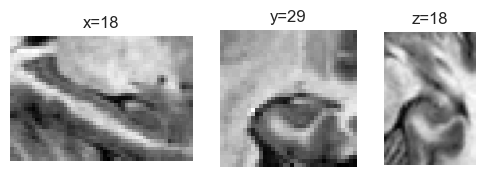

Sobel


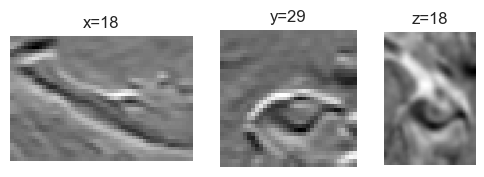

Guassian


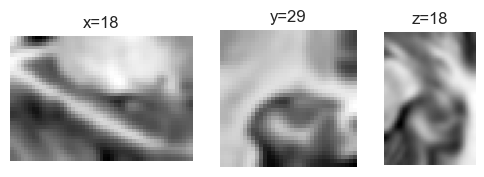

Guassian 2nd order


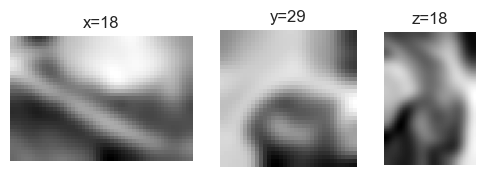

Guassian 2nd minus 1st order


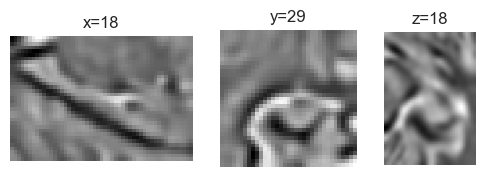

Rank


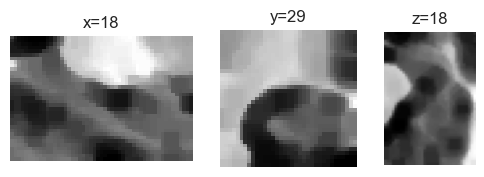

Laplace


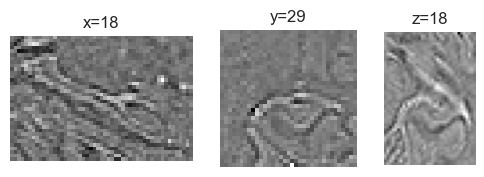

Median


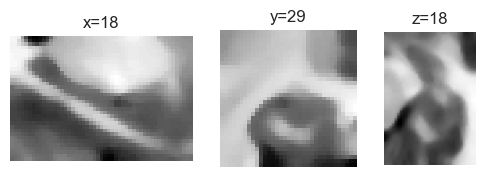

GGM


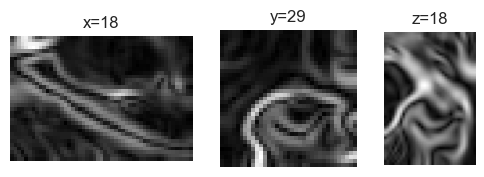

In [73]:
data, data_lab = load_image("001", train_path, labels_train)

def display_filters(dat, filter_name, x=18, y=29, z=18, mycmap="gray"):
  fig, axs = plt.subplots(1, 3, figsize=(6, 10), gridspec_kw={'width_ratios': [2, 1.5, 1]})

  axs[0].imshow(dat[x,:,::-1].T, cmap=mycmap)
  axs[1].imshow(dat[::-1,y,::-1].T, cmap=mycmap)
  axs[2].imshow(dat[::-1,::-1,z].T, cmap=mycmap)

  axs[0].set_title('x=' + str(x))
  axs[1].set_title('y=' + str(y))
  axs[2].set_title('z=' + str(z))

  axs[0].axis('off')
  axs[1].axis('off')
  axs[2].axis('off')
  print(filter_name)
  plt.show()

res = data
sob = ndimage.sobel(data)
gau = ndimage.gaussian_filter(data, sigma=1)
gau2 = ndimage.gaussian_filter(data, sigma=2)
rank = ndimage.rank_filter(data, rank=5, size=5)
laplace = ndimage.laplace(data)
median = ndimage.median_filter(data, size=5)
ggm = ndimage.gaussian_gradient_magnitude(data, sigma=1)

display_filters(data, 'raw')
display_filters(sob, 'Sobel')
display_filters(gau, 'Guassian')
display_filters(gau2, 'Guassian 2nd order')
display_filters(gau2-gau, 'Guassian 2nd minus 1st order')
display_filters(rank, 'Rank')
display_filters(laplace, 'Laplace')
display_filters(median, 'Median')
display_filters(ggm, 'GGM')

### I take my best model so far to test these new filters (with the previous best sample size and cube dimensions)

In [74]:
# Redefine this function, for creating data sets with extra filters

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    # rank,
    # laplace,
    # median,
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

cube_dim = 11

def get_vali_results_filter():
  # Remake training set based on these new filters
  Y_new, X_new, sampleIDs_new = create_training_set(train_path, labels_train, pdim=11)
  Xsub_new, Ysub_new, sub_idx_new = sub_sample(X_new, Y_new, sample_size=4000)

  xgbc = XGBClassifier(
      max_depth = clf.best_params_['max_depth'],
      n_estimators = clf.best_params_['n_estimators']
  )

  xgbc.fit(Xsub_new, Ysub_new)

  Ys, Xs, full_imgs, full_labs, sample_ids = create_vali_set(vali_path, labels_vali, pdim=cube_dim, sample_freq=1, verbose=False)
  roc_list, dice_list, best_id, best_prediction = output_vali_results(
      Ys, Xs, full_imgs, full_labs, sample_ids, pdim=cube_dim, model=xgbc, verbose=False
  )

  auc_mean = np.mean(roc_list)
  dice_mean = np.mean(dice_list)

  print(auc_mean)
  print(dice_mean)

### Try adding each of the filters incrementally to see if they improve score

In [75]:
# No extra filters

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    # rank,
    # laplace,
    # median,
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 3 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 3 channels. Sampling with frequency 1 from each image.
0.8085397239692671
0.7302783383663488


In [76]:
# Laplace

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    # rank,
    laplace,
    # median,
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 1 from each image.
0.796993727443185
0.7131842823115792


In [77]:
# Rank

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    rank,
    # laplace,
    # median,
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 1 from each image.
0.820550631002118
0.7483061355777001


In [78]:
# Median

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    # rank,
    # laplace,
    median,
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 1 from each image.
0.8059856879747818
0.7294632648887986


In [79]:
# Gaussian Gradient magnitude

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)
  ggm = ndimage.gaussian_gradient_magnitude(dat, sigma=1)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    ggm
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 4 channels. Sampling with frequency 1 from each image.
0.811242356135178
0.7392163257344493


### The rank and ggm filters improved the score, so I'll now try to combine them

In [80]:
# Rank + Gaussian Gradient magnitude

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)
  ggm = ndimage.gaussian_gradient_magnitude(dat, sigma=1)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    rank,
    ggm
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

get_vali_results_filter()

Extracting cubes of size 11^3 and 5 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 5 channels. Sampling with frequency 1 from each image.
0.8223218997342894
0.755252005762898


### In the end, the combination of the additional filters: Rank and GGM improved the Validation Dice Score from 0.730 to 0.755

## (f) Apply to test set

### Just to be clear I redefine the preprocess function with the 2 additional filters, and use cube_dim = 11, and sample size 4000

In [81]:
# Rank + Gaussian Gradient magnitude

def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)

  # new filters
  rank = ndimage.rank_filter(dat, rank=5, size=5)
  laplace = ndimage.laplace(dat)
  median = ndimage.median_filter(dat, size=5)
  ggm = ndimage.gaussian_gradient_magnitude(dat, sigma=1)

  #concatenate original image with
  tmp = [
    res, 
    sob, 
    gau2 - gau,
    rank,
    ggm
  ]
  res = np.stack(tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

### Redefine output function to output the best and worst samples

In [95]:
def output_test_results(Ys, Xs, full_imgs, full_labs, sample_ids, pdim, model, verbose=True):
    roc_list = []
    dice_list = []
    best_prediction = None
    best_dice_score = 0
    best_id = None
    worst_prediction = None
    worst_dice_score = np.inf
    worst_id = None

    if pdim % 2 != 1:
        print("Cube size must be odd!")
        return

    pad_width = int((pdim - 1) / 2)

    for i in range(len(Ys)):

        id = sample_ids[i]
        full_lab = full_labs[i]
        
        prediction = model.predict(Xs[i])
        prediction_full = prediction.reshape(
            full_lab.shape[0] - pad_width * 2,
            full_lab.shape[1] - pad_width * 2,
            full_lab.shape[2] - pad_width * 2,
        )
        # Predict 0 for the outer 2 layers of the images, since the 5x5x5 cubes of features used for
        # prediction won't extend to give predictions on those sides
        prediction_full = np.pad(prediction_full, pad_width=pad_width, mode='constant', constant_values=0)

        roc_auc = roc_auc_score(prediction_full.flatten(), full_lab.flatten())

        # Dice Score is equivalent to f1 score when looking at each pixel as a separate prediction
        dice_score = f1_score(prediction_full.flatten(), full_lab.flatten())

        roc_list.append(roc_auc)
        dice_list.append(dice_score)

        if dice_score > best_dice_score:
            best_id = id
            best_prediction = prediction_full
            best_dice_score = dice_score
        if dice_score < worst_dice_score:
            worst_id = id
            worst_prediction = prediction_full
            worst_dice_score = dice_score

        if verbose:
            print(f'For image {sample_ids[i]}: ROC AUC: {roc_auc}, Dice Score: {dice_score}')

    return roc_list, dice_list, best_id, best_prediction, worst_id, worst_prediction

In [96]:
Y_new, X_new, sampleIDs_new = create_training_set(train_path, labels_train, pdim=11)
Xsub_new, Ysub_new, sub_idx_new = sub_sample(X_new, Y_new, sample_size=4000)

xgbc = XGBClassifier(
    max_depth = clf.best_params_['max_depth'],
    n_estimators = clf.best_params_['n_estimators']
)

xgbc.fit(Xsub_new, Ysub_new)

# Create test set
Ys_test, Xs_test, full_imgs_test, full_labs_test, sample_ids_test = create_vali_set(
    test_path, labels_test, pdim=11, sample_freq=1, verbose=True
)

roc_list, dice_list, best_id, best_prediction, worst_id, worst_prediction = output_test_results(
    Ys_test, Xs_test, full_imgs_test, full_labs_test, sample_ids_test, pdim=cube_dim, model=xgbc, verbose=False
)

Extracting cubes of size 11^3 and 5 channels. Sampling with frequency 0.01 from each image.
sampling with ratio 1:8.611618560467665
Extracting cubes of size 11^3 and 5 channels. Sampling with frequency 1 from each image.
working on Image ID: 366
working on Image ID: 367
working on Image ID: 368
working on Image ID: 370
working on Image ID: 372
working on Image ID: 373
working on Image ID: 374
working on Image ID: 375
working on Image ID: 376
working on Image ID: 378


In [97]:
pd.DataFrame(
    {
        'ID': sample_ids_test,
        'ROC': roc_list,
        'Dice Score': dice_list
    }
)

,ID,ROC,Dice Score
0,366,0.877077,0.827214
1,367,0.803526,0.735842
2,368,0.782633,0.695505
3,370,0.877806,0.780862
4,372,0.833208,0.769684
5,373,0.858238,0.815033
6,374,0.846238,0.798018
7,375,0.802576,0.737319
8,376,0.818860,0.742844
9,378,0.808202,0.748818


In [98]:
# Average scores

print(f'Average test ROC AUC: {np.mean(roc_list)}')
print(f'Average test Dice Score: {np.mean(dice_list)}')

Average test ROC AUC: 0.8308363213361618
Average test Dice Score: 0.7651138483234646


366
True label


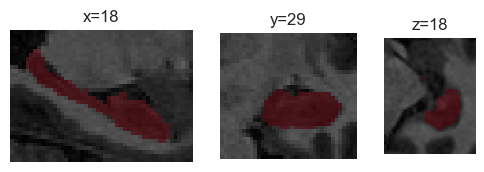

Prediction


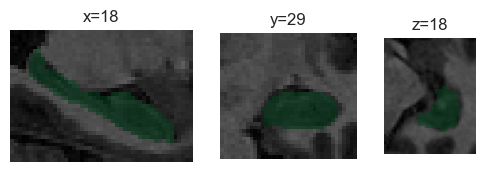

In [99]:
print(best_id)
data, data_lab = load_image(str(best_id), test_path, labels_test)
print('True label')
displayNew(data, over=data_lab, overcut=0.0, cmap_lab='Reds')
data, data_lab = load_image(str(best_id), test_path, labels_test)
print('Prediction')
displayNew(data, over=best_prediction.astype(float), overcut=0.0, cmap_lab='Greens')

368
True label


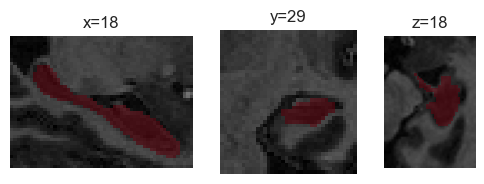

Prediction


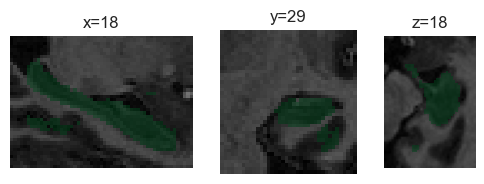

In [100]:
print(worst_id)
data, data_lab = load_image(str(worst_id), test_path, labels_test)
print('True label')
displayNew(data, over=data_lab, overcut=0.0, cmap_lab='Reds')
data, data_lab = load_image(str(worst_id), test_path, labels_test)
print('Prediction')
displayNew(data, over=worst_prediction.astype(float), overcut=0.0, cmap_lab='Greens')

## End